In [1]:
import sys
import os
import time
import math
import numpy as np
import logging

In [2]:
# mesh libraries
import meshio
import pygmsh
import gmsh
from msh_to_xdmf import msh_to_xdmf

In [3]:
# load fenics
import dolfin as dl

logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

np.random.seed(seed=0)

In [4]:
# matplotlib for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axisartist.axislines import Subplot
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.tri as tri

In [ ]:
# Function to read mesh. From link - https://jsdokken.com/src/pygmsh_tutorial.html
def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    cell_data = mesh.get_cell_data("gmsh:physical", cell_type)
    points = mesh.points[:,:2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells}, cell_data={"name_to_read":[cell_data]})
    return out_mesh

In [46]:
def write_point_geo(geof, p_id, x, h):
    geof.write("Point(%d) = {%4.6e, %4.6e, %4.6e, %4.6e};\n" % (p_id, x[0], x[1], x[2], h))
    return p_id + 1

def write_line_geo(geof, l_id, p1_id, p2_id):
    geof.write("Line(%d) = {%d, %d};\n" % (l_id, p1_id, p2_id))
    return l_id + 1

def write_cir_line_geo(geof, l_id, p1_id, p2_id, p3_id):
    geof.write("Circle(%d) = {%d, %d, %d};\n" % (l_id, p1_id, p2_id, p3_id))
    return l_id + 1

# Square with a hole

Consider the following domain:

<img src="./square_with_hole/domain.png" style="width:200px;">

## Method 1: generate mesh using command line
To mesh the domain using `gmsh` library, we first create a `.geo` file and then call gmsh command to create the corresponding mesh.

### Step 1: Create geo file for gmsh

In [90]:
# horizon and mesh size
h = 0.01

# Domain
L = 1
W = 1

# Parameters for hole

# first hole
xc1 = 0.375
xc2 = 0.375
r = 0.125

# create mesh dir and filename
mesh_dir = './square_with_hole/'
os.makedirs(mesh_dir, exist_ok = True)

mesh_tag = 'mesh' + '_h_{:2.3f}'.format(h) 
mesh_fname = mesh_dir + mesh_tag

# create gmsh input file
geof = open(mesh_fname + '.geo','w')
geof.write("cl__1 = 1;\n")
geof.write("Mesh.MshFileVersion = 2.2;\n")

# four corners of domain
geof.write("Point(1) = {0, 0, 0, %4.6e};\n" % (h))
geof.write("Point(2) = {%4.6e, 0, 0, %4.6e};\n" % (L, h))
geof.write("Point(3) = {%4.6e, %4.6e, 0, %4.6e};\n" % (L, W, h))
geof.write("Point(4) = {0, %4.6e, 0, %4.6e};\n" % (W,h))

# points for hole
# four points on circle of hole and one center point of hole
#
#                          + P7
# 
#				
#	
#	           P8                      P9
#					+				o				+
#                          P5
#	
#
#	
#                          + P6
#
geof.write("Point(5) = {%4.6e, %4.6e, 0, %4.6e};\n" % (xc1, xc2, h))
geof.write("Point(6) = {%4.6e, %4.6e, 0, %4.6e};\n" % (xc1, xc2 - r, h))
geof.write("Point(7) = {%4.6e, %4.6e, 0, %4.6e};\n" % (xc1, xc2 + r, h))
geof.write("Point(8) = {%4.6e, %4.6e, 0, %4.6e};\n" % (xc1 - r, xc2, h))
geof.write("Point(9) = {%4.6e, %4.6e, 0, %4.6e};\n" % (xc1 + r, xc2, h))

# lines to form outer boundary
geof.write("Line(1) = {1, 2};\n")
geof.write("Line(2) = {2, 3};\n")
geof.write("Line(3) = {3, 4};\n")
geof.write("Line(4) = {4, 1};\n")

# first hole: circular line forming inner boundary
geof.write("Circle(5) = {8, 5, 7};\n")
geof.write("Circle(6) = {7, 5, 9};\n")
geof.write("Circle(7) = {9, 5, 6};\n")
geof.write("Circle(8) = {6, 5, 8};\n")

# line loop to define surface
geof.write("Line Loop(9) = {3, 4, 1, 2};\n")
geof.write("Line Loop(10) = {5, 6, 7, 8};\n")

# define surface
geof.write("Plane Surface(11) = {9, 10};\n")

# define physical groups
geof.write("Physical Point(12) = {1, 2, 3, 4, 8, 6, 9};\n")

geof.write("Physical Line(13) = {1, 2, 3, 4, 5, 6, 7, 8};\n")

geof.write("Physical Surface(14) = {11};\n")

# close file
geof.close()

### Step 2: Run gmsh

In [91]:
os.system('gmsh ' + mesh_fname + '.geo -2')
os.system('gmsh ' + mesh_fname + '.geo -2 -o ' + mesh_fname + '.vtk')

Info    : Running '/Users/prashant/opt/anaconda3/envs/confen/bin/gmsh ./square_with_hole/mesh_h_0.010.geo -2' [Gmsh 4.12.2, 1 node, max. 1 thread]
Info    : Started on Sun Mar  3 17:46:04 2024
Info    : Reading './square_with_hole/mesh_h_0.010.geo'...
Info    : Done reading './square_with_hole/mesh_h_0.010.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 50%] Meshing curve 5 (Circle)
Info    : [ 70%] Meshing curve 6 (Circle)
Info    : [ 80%] Meshing curve 7 (Circle)
Info    : [ 90%] Meshing curve 8 (Circle)
Info    : Done meshing 1D (Wall 0.00102142s, CPU 0.002798s)
Info    : Meshing 2D...
Info    : Meshing surface 11 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.377984s, CPU 0.734095s)
Info    : 11458 nodes 22923 elements
Info    : Writing './square_with_hole/mesh_h_0.010.msh'...
Info    : Done writing './square_with_hole

0

### Step 3: Read mesh using meshio and convert to xdmf format for fenics

In [93]:
mesh_from_file = meshio.read(mesh_fname + ".msh")

triangle_mesh = create_mesh(mesh_from_file, "triangle", prune_z=True)
meshio.write(mesh_fname + ".xdmf", triangle_mesh)

line_mesh = create_mesh(mesh_from_file, "line", prune_z=True)
meshio.write(mesh_fname + "_facet.xdmf", line_mesh)

### Step 4 (Optional): Plot mesh using fenics plot function

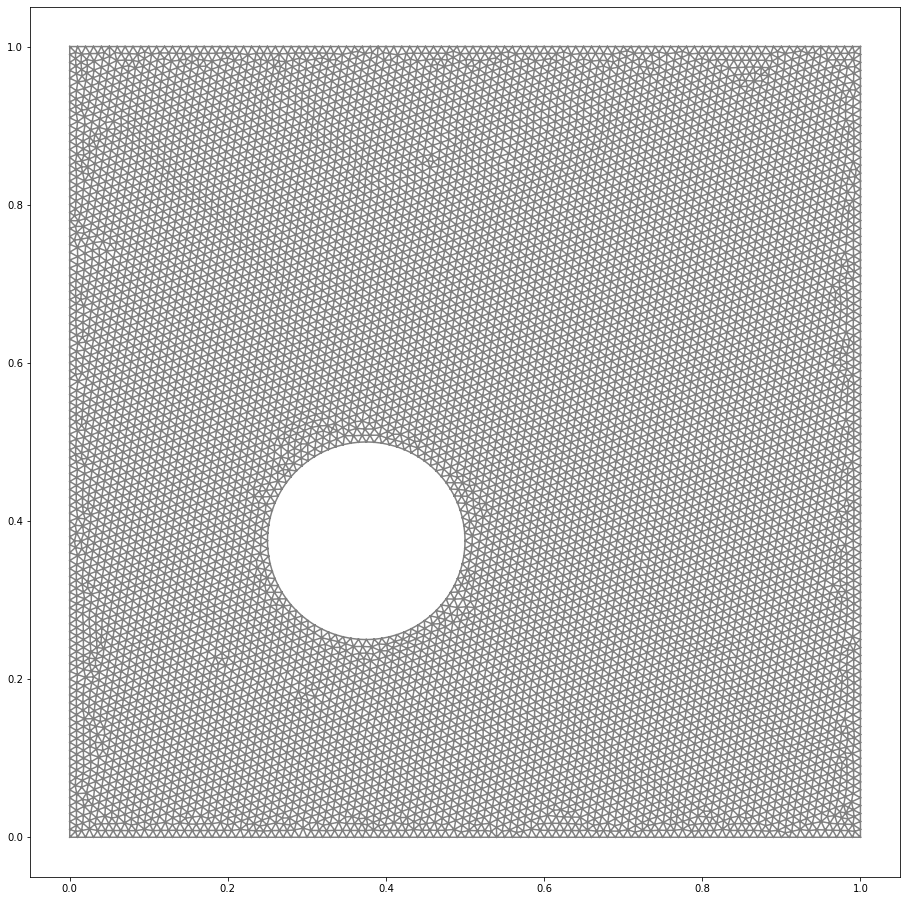

In [94]:
mesh = dl.Mesh()
# read xdmf file in fenics
with dl.XDMFFile(mesh_fname + '.xdmf') as infile:
    infile.read(mesh)

mvc = dl.MeshValueCollection("size_t", mesh, 2)
with dl.XDMFFile(mesh_fname + '_facet.xdmf') as infile:
    infile.read(mvc, "name_to_read")
    
sub = dl.cpp.mesh.MeshFunctionSizet(mesh, mvc)

# plot
plt.figure(figsize=(16,16))
dl.plot(mesh)

# save figures
plt.savefig(mesh_fname + '.pdf')
plt.savefig(mesh_fname + '.png')

plt.show()

## Method 2: generate mesh using pygmsh from python
This part is from the pygmsh tutorial in the [link](https://jsdokken.com/src/pygmsh_tutorial.html).

### Step 1: Create geometry using pygmsh

In [95]:
# horizon and mesh size
h = 0.01

# Domain
L = 1
W = 1

# Parameters for hole

# first hole
xc1 = 0.375
xc2 = 0.375
r = 0.125

# create mesh dir and filename
mesh_dir = './square_with_hole_pygmsh/'
os.makedirs(mesh_dir, exist_ok = True)

mesh_tag = 'mesh' + '_h_{:2.3f}'.format(h)
mesh_fname = mesh_dir + mesh_tag

# Initialize empty geometry using the build in kernel in GMSH
geometry = pygmsh.geo.Geometry()

# Fetch model we would like to add data to
model = geometry.__enter__()

# Add circle
circle = model.add_circle([xc1, xc2], r, mesh_size=h)

# ---- #
# The next step is to create the channel with the circle as a hole.
# ---- #

# Add points with finer resolution on left side
points = [model.add_point((0, 0, 0), mesh_size=h),
          model.add_point((L, 0, 0), mesh_size=5*h),
          model.add_point((L, W, 0), mesh_size=5*h),
          model.add_point((0, W, 0), mesh_size=h)]

# Add lines between all points creating the rectangle
channel_lines = [model.add_line(points[i], points[i+1])
                 for i in range(-1, len(points)-1)]

# Create a line loop and plane surface for meshing
channel_loop = model.add_curve_loop(channel_lines)
plane_surface = model.add_plane_surface(
    channel_loop, holes=[circle.curve_loop])

# Call gmsh kernel before add physical entities
model.synchronize()

# ---- #
# The final step before mesh generation is to mark the different boundaries and the volume mesh. 
# Note that with pygmsh, boundaries with the same tag has to be added simultaneously. 
# In this example this means that we have to add the top and bottom wall in one function call.
# ---- #
volume_marker = 6
model.add_physical([plane_surface], "Volume")
model.add_physical([channel_lines[0]], "Inflow")
model.add_physical([channel_lines[2]], "Outflow")
model.add_physical([channel_lines[1], channel_lines[3]], "Walls")
model.add_physical(circle.curve_loop.curves, "Obstacle")

### Step 2: Mesh using gmsh python command

In [96]:
# ---- #
# We generate the mesh using the pygmsh function generate_mesh. 
# Generate mesh returns a meshio.Mesh. However, this mesh is tricky to extract physical tags from. 
# Therefore we write the mesh to file using the gmsh.write function.
# ---- #
geometry.generate_mesh(dim=2)
gmsh.write(mesh_fname + ".msh")
gmsh.clear()
geometry.__exit__()

### Step 3: Read mesh using meshio and convert to xdmf format for fenics

In [97]:
mesh_from_file = meshio.read(mesh_fname + ".msh")

line_mesh = create_mesh(mesh_from_file, "line", prune_z=True)
meshio.write(mesh_fname + "_facet.xdmf", line_mesh)

triangle_mesh = create_mesh(mesh_from_file, "triangle", prune_z=True)
meshio.write(mesh_fname + ".xdmf", triangle_mesh)

### Step 4 (Optional): Plot mesh using fenics plot function

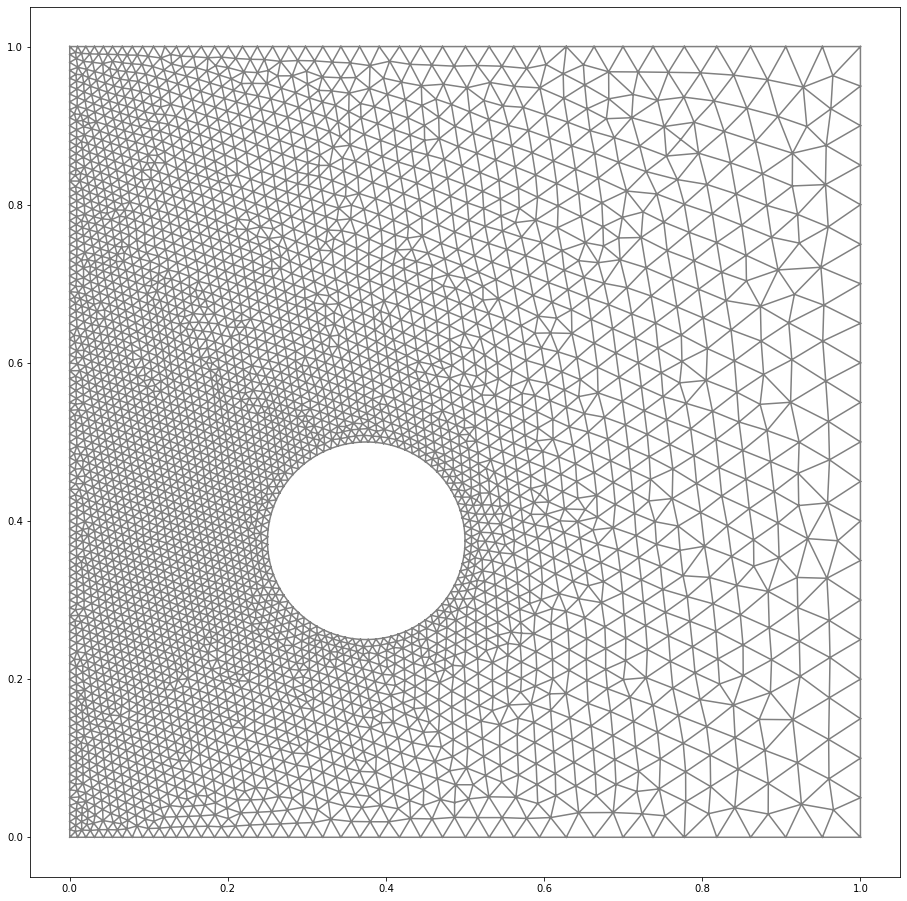

In [98]:
mesh = dl.Mesh()
# read xdmf file in fenics
with dl.XDMFFile(mesh_fname + '.xdmf') as infile:
    infile.read(mesh)

mvc = dl.MeshValueCollection("size_t", mesh, 2)
with dl.XDMFFile(mesh_fname + '_facet.xdmf') as infile:
    infile.read(mvc, "name_to_read")
    
sub = dl.cpp.mesh.MeshFunctionSizet(mesh, mvc)

# plot
plt.figure(figsize=(16,16))
dl.plot(mesh)

# save figures
plt.savefig(mesh_fname + '.pdf')
plt.savefig(mesh_fname + '.png')

plt.show()

# Rectangle with two holes

Consider the following domain:

<img src="rectangle_with_two_holes/domain.png" style="width:200px;">

## Method 1: generate mesh using command line
To mesh the domain using `gmsh` library, we first create a `.geo` file and then call gmsh command to create the corresponding mesh.

### Step 1: Create geo file for gmsh

In [103]:
# horizon and mesh size
h = 0.02

# Domain
L = 0.8
W = 1.2

# Parameters for hole

# first hole
xc11 = 0.2*L
xc12 = 0.8*W
r1 = 0.1*L

# second hole
xc21 = 0.7*L
xc22 = 0.3*W
r2 = 0.2*L

# create mesh dir and filename
mesh_dir = './rectangle_with_two_holes/'
os.makedirs(mesh_dir, exist_ok = True)

mesh_tag = 'mesh' + '_h_{:2.3f}'.format(h) 
mesh_fname = mesh_dir + mesh_tag

# create gmsh input file
geof = open(mesh_fname + '.geo','w')
geof.write("cl__1 = 1;\n")
geof.write("Mesh.MshFileVersion = 2.2;\n")

# four corners of domain
geof.write("Point(1) = {0, 0, 0, %4.6e};\n" % (h))
geof.write("Point(2) = {%4.6e, 0, 0, %4.6e};\n" % (L, h))
geof.write("Point(3) = {%4.6e, %4.6e, 0, %4.6e};\n" % (L, W, h))
geof.write("Point(4) = {0, %4.6e, 0, %4.6e};\n" % (W,h))

# points for first hole
# four points on circle of hole and one center point of hole
#
#                          + P7
# 
#				
#	
#	           P8                      P9
#					+				o				+
#                          P5
#	
#
#	
#                          + P6
#
geof.write("Point(5) = {%4.6e, %4.6e, 0, %4.6e};\n" % (xc11, xc12, h))
geof.write("Point(6) = {%4.6e, %4.6e, 0, %4.6e};\n" % (xc11, xc12 - r1, h))
geof.write("Point(7) = {%4.6e, %4.6e, 0, %4.6e};\n" % (xc11, xc12 + r1, h))
geof.write("Point(8) = {%4.6e, %4.6e, 0, %4.6e};\n" % (xc11 - r1, xc12, h))
geof.write("Point(9) = {%4.6e, %4.6e, 0, %4.6e};\n" % (xc11 + r1, xc12, h))

# points for second hole
# four points on circle of hole and one center point of hole
#
#                          + P12
# 
#				
#	
#	           P13                      P14
#					+				o				+
#                          P10
#	
#
#	
#                          + P11
#
geof.write("Point(10) = {%4.6e, %4.6e, 0, %4.6e};\n" % (xc21, xc22, h))
geof.write("Point(11) = {%4.6e, %4.6e, 0, %4.6e};\n" % (xc21, xc22 - r2, h))
geof.write("Point(12) = {%4.6e, %4.6e, 0, %4.6e};\n" % (xc21, xc22 + r2, h))
geof.write("Point(13) = {%4.6e, %4.6e, 0, %4.6e};\n" % (xc21 - r2, xc22, h))
geof.write("Point(14) = {%4.6e, %4.6e, 0, %4.6e};\n" % (xc21 + r2, xc22, h))

# lines to form outer boundary
geof.write("Line(1) = {1, 2};\n")
geof.write("Line(2) = {2, 3};\n")
geof.write("Line(3) = {3, 4};\n")
geof.write("Line(4) = {4, 1};\n")

# first hole: circular line forming inner boundary
geof.write("Circle(5) = {8, 5, 7};\n")
geof.write("Circle(6) = {7, 5, 9};\n")
geof.write("Circle(7) = {9, 5, 6};\n")
geof.write("Circle(8) = {6, 5, 8};\n")

# second hole: circular line forming inner boundary
geof.write("Circle(9) = {13, 10, 12};\n")
geof.write("Circle(10) = {12, 10, 14};\n")
geof.write("Circle(11) = {14, 10, 11};\n")
geof.write("Circle(12) = {11, 10, 13};\n")

# line loop to define surface
geof.write("Line Loop(13) = {3, 4, 1, 2};\n")
geof.write("Line Loop(14) = {5, 6, 7, 8};\n")
geof.write("Line Loop(15) = {9, 10, 11, 12};\n")

# define surface
geof.write("Plane Surface(16) = {13, 14, 15};\n")

# define physical groups
geof.write("Physical Point(17) = {1, 2, 3, 4, 8, 6, 9, 7, 11, 12, 13, 14};\n")

geof.write("Physical Line(18) = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12};\n")

geof.write("Physical Surface(19) = {16};\n")

# close file
geof.close()

### Step 2: Run gmsh

In [104]:
os.system('gmsh ' + mesh_fname + '.geo -2')
os.system('gmsh ' + mesh_fname + '.geo -2 -o ' + mesh_fname + '.vtk')

Info    : Running '/Users/prashant/opt/anaconda3/envs/confen/bin/gmsh ./rectangle_with_two_holes/mesh_h_0.020.geo -2' [Gmsh 4.12.2, 1 node, max. 1 thread]
Info    : Started on Sun Mar  3 18:17:21 2024
Info    : Reading './rectangle_with_two_holes/mesh_h_0.020.geo'...
Info    : Done reading './rectangle_with_two_holes/mesh_h_0.020.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Circle)
Info    : [ 50%] Meshing curve 6 (Circle)
Info    : [ 50%] Meshing curve 7 (Circle)
Info    : [ 60%] Meshing curve 8 (Circle)
Info    : [ 70%] Meshing curve 9 (Circle)
Info    : [ 80%] Meshing curve 10 (Circle)
Info    : [ 90%] Meshing curve 11 (Circle)
Info    : [100%] Meshing curve 12 (Circle)
Info    : Done meshing 1D (Wall 0.00109163s, CPU 0.002771s)
Info    : Meshing 2D...
Info    : Meshing surface 16 (Plane, Frontal-Delaunay)
I

0

### Step 3: Read mesh using meshio and convert to xdmf format for fenics

In [105]:
mesh_from_file = meshio.read(mesh_fname + ".msh")

triangle_mesh = create_mesh(mesh_from_file, "triangle", prune_z=True)
meshio.write(mesh_fname + ".xdmf", triangle_mesh)

line_mesh = create_mesh(mesh_from_file, "line", prune_z=True)
meshio.write(mesh_fname + "_facet.xdmf", line_mesh)

### Step 4 (Optional): Plot mesh using fenics plot function

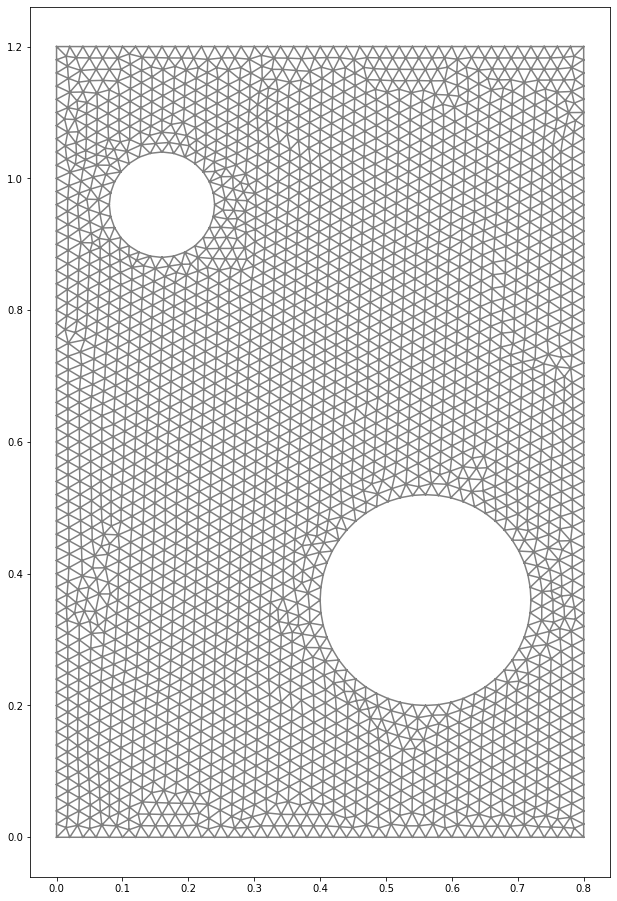

In [106]:
mesh = dl.Mesh()
# read xdmf file in fenics
with dl.XDMFFile(mesh_fname + '.xdmf') as infile:
    infile.read(mesh)

mvc = dl.MeshValueCollection("size_t", mesh, 2)
with dl.XDMFFile(mesh_fname + '_facet.xdmf') as infile:
    infile.read(mvc, "name_to_read")
    
sub = dl.cpp.mesh.MeshFunctionSizet(mesh, mvc)

# plot
plt.figure(figsize=(16,16))
dl.plot(mesh)

# save figures
plt.savefig(mesh_fname + '.pdf')
plt.savefig(mesh_fname + '.png')

plt.show()

# Three-dimensional mesh

In [115]:
# Clear previous model
h = 0.1
geom = pygmsh.occ.Geometry()
model3D = geom.__enter__()
box0 = model3D.add_box([0.0, 0, 0], [1, 1, 1], mesh_size=h)
box1 = model3D.add_box([0.5, 0.5, 1], [0.5, 0.5, 1], mesh_size=h)
ball = model3D.add_ball([0.5, 0.5, 0.5], 0.25, mesh_size=h)

In [116]:
union = model3D.boolean_union([box0, box1])
union_minus_ball = model3D.boolean_fragments(union, ball)
model3D.synchronize()

/Users/prashant/opt/anaconda3/envs/confen/lib/python3.8/site-packages/pygmsh/occ/geometry.py:189: UserWarning: Specified mesh size for <pygmsh.occ.box.Box object at 0x7fe7da62b940> discarded in Boolean union operation.
  warnings.warn(
/Users/prashant/opt/anaconda3/envs/confen/lib/python3.8/site-packages/pygmsh/occ/geometry.py:189: UserWarning: Specified mesh size for <pygmsh.occ.box.Box object at 0x7fe7c8c6ff10> discarded in Boolean union operation.
  warnings.warn(


In [117]:
model3D.add_physical(union, "Union")
model3D.add_physical(union_minus_ball, "Union minus ball")

In [118]:
# create mesh dir and filename
mesh_dir = './mesh_3d/'
os.makedirs(mesh_dir, exist_ok = True)

mesh_tag = 'mesh' + '_h_{:2.3f}'.format(h) 
mesh_fname = mesh_dir + mesh_tag

# create mesh
geom.generate_mesh(dim=3)
gmsh.write(mesh_fname + ".msh")
model3D.__exit__()

In [120]:
msh_to_xdmf(mesh_fname, False)

## Rectangle with rectangle void

Info    : Running '/Users/prashant/opt/anaconda3/envs/confen/bin/gmsh ./rectangle_with_rectangle_hole/mesh_h_1.000000e-02.geo -2' [Gmsh 4.12.2, 1 node, max. 1 thread]
Info    : Started on Fri Jun 14 00:38:03 2024
Info    : Reading './rectangle_with_rectangle_hole/mesh_h_1.000000e-02.geo'...
Info    : Done reading './rectangle_with_rectangle_hole/mesh_h_1.000000e-02.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 50%] Meshing curve 5 (Line)
Info    : [ 70%] Meshing curve 6 (Line)
Info    : [ 80%] Meshing curve 7 (Line)
Info    : [ 90%] Meshing curve 8 (Line)
Info    : Done meshing 1D (Wall 0.000837482s, CPU 0.00228s)
Info    : Meshing 2D...
Info    : Meshing surface 11 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0272198s, CPU 0.07781s)
Info    : 1064 nodes 2136 elements
Info    : Writing './rectangle_with_rectangle_hole/

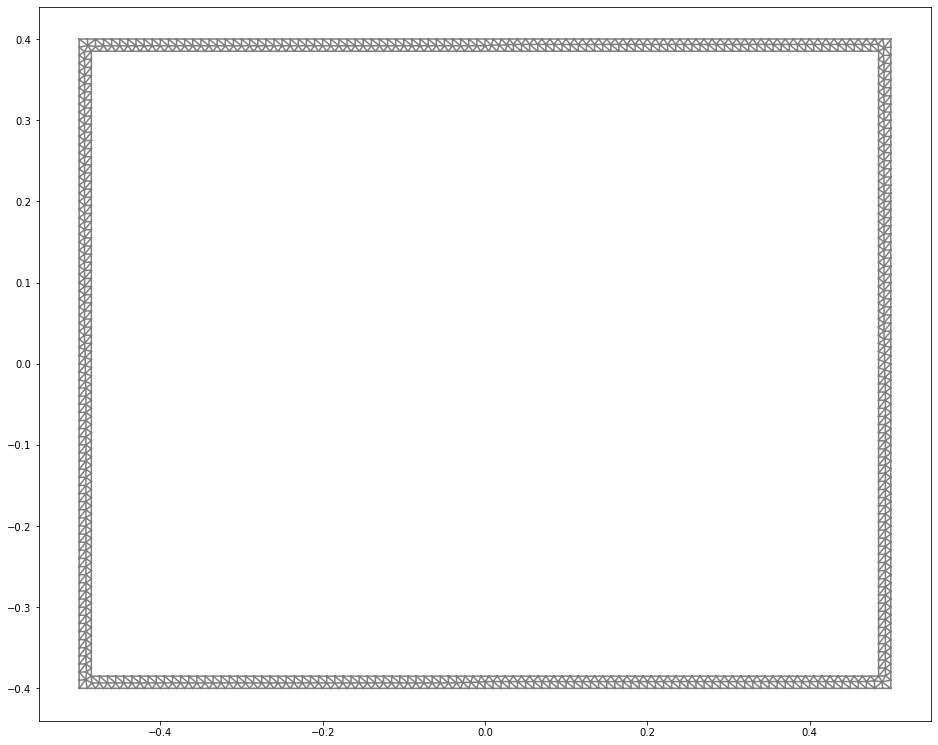

In [51]:
# horizon and mesh size
h = 0.01

# Domain
L = 1
W = 0.8

# Parameters for hole

# square hole center
xc1 = 0
xc2 = 0
Lin = L - 3*h
Win = W - 3*h

# create mesh dir and filename
mesh_dir = './rectangle_with_rectangle_hole/'
os.makedirs(mesh_dir, exist_ok = True)

mesh_tag = 'mesh' + '_h_{:4.6e}'.format(h) 
mesh_fname = mesh_dir + mesh_tag

# create gmsh input file
geof = open(mesh_fname + '.geo','w')
geof.write("cl__1 = 1;\n")
geof.write("Mesh.MshFileVersion = 2.2;\n")

# four corners of domain
geof.write("Point(1) = {%4.6e, %4.6e, 0, %4.6e};\n" % (-0.5*L, -0.5*W, h))
geof.write("Point(2) = {%4.6e, %4.6e, 0, %4.6e};\n" % (0.5*L, -0.5*W, h))
geof.write("Point(3) = {%4.6e, %4.6e, 0, %4.6e};\n" % (0.5*L, 0.5*W, h))
geof.write("Point(4) = {%4.6e, %4.6e, 0, %4.6e};\n" % (-0.5*L, 0.5*W,h))

# four points on rectangle hole
geof.write("Point(5) = {%4.6e, %4.6e, 0, %4.6e};\n" % (-0.5*Lin, -0.5*Win, h))
geof.write("Point(6) = {%4.6e, %4.6e, 0, %4.6e};\n" % (0.5*Lin, -0.5*Win, h))
geof.write("Point(7) = {%4.6e, %4.6e, 0, %4.6e};\n" % (0.5*Lin, 0.5*Win, h))
geof.write("Point(8) = {%4.6e, %4.6e, 0, %4.6e};\n" % (-0.5*Lin, 0.5*Win, h))

# lines to form outer boundary
geof.write("Line(1) = {1, 2};\n")
geof.write("Line(2) = {2, 3};\n")
geof.write("Line(3) = {3, 4};\n")
geof.write("Line(4) = {4, 1};\n")

# first hole: line forming inner boundary
geof.write("Line(5) = {8, 7};\n")
geof.write("Line(6) = {7, 6};\n")
geof.write("Line(7) = {6, 5};\n")
geof.write("Line(8) = {5, 8};\n")

# line loop to define surface
geof.write("Line Loop(9) = {3, 4, 1, 2};\n")
geof.write("Line Loop(10) = {5, 6, 7, 8};\n")

# define surface
geof.write("Plane Surface(11) = {9, 10};\n")

# define physical groups
geof.write("Physical Point(12) = {1, 2, 3, 4, 8, 7, 6, 5};\n")

geof.write("Physical Line(13) = {1, 2, 3, 4, 5, 6, 7, 8};\n")

geof.write("Physical Surface(14) = {11};\n")

# close file
geof.close()

## meshing
os.system('gmsh ' + mesh_fname + '.geo -2')
os.system('gmsh ' + mesh_fname + '.geo -2 -o ' + mesh_fname + '.vtk')

## convert mesh
mesh_from_file = meshio.read(mesh_fname + ".msh")

triangle_mesh = create_mesh(mesh_from_file, "triangle", prune_z=True)
meshio.write(mesh_fname + ".xdmf", triangle_mesh)

line_mesh = create_mesh(mesh_from_file, "line", prune_z=True)
meshio.write(mesh_fname + "_facet.xdmf", line_mesh)

## plot
mesh = dl.Mesh()
# read xdmf file in fenics
with dl.XDMFFile(mesh_fname + '.xdmf') as infile:
    infile.read(mesh)

mvc = dl.MeshValueCollection("size_t", mesh, 2)
with dl.XDMFFile(mesh_fname + '_facet.xdmf') as infile:
    infile.read(mvc, "name_to_read")
    
sub = dl.cpp.mesh.MeshFunctionSizet(mesh, mvc)

# plot
plt.figure(figsize=(16,16))
dl.plot(mesh)

# save figures
plt.savefig(mesh_fname + '.pdf')
plt.savefig(mesh_fname + '.png')

plt.show()

## Rectangle (square) with rectangle (square) void and rectangle opening

Info    : Running '/Users/prashant/opt/anaconda3/envs/confen/bin/gmsh ./rectangle_with_rectangle_hole_with_opening/mesh_h_1.000000e-02.geo -2' [Gmsh 4.12.2, 1 node, max. 1 thread]
Info    : Started on Fri Jun 14 00:38:39 2024
Info    : Reading './rectangle_with_rectangle_hole_with_opening/mesh_h_1.000000e-02.geo'...
Info    : Done reading './rectangle_with_rectangle_hole_with_opening/mesh_h_1.000000e-02.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 60%] Meshing curve 8 (Line)
Info    : [ 70%] Meshing curve 9 (Line)
Info    : [ 80%] Meshing curve 10 (Line)
Info    : [ 90%] Meshing curve 11 (Line)
Info    : [100%] Meshing curve 12 (Line)
Info    : Done meshing 1D (Wall 0.00105652s, CPU 0.002704s)
Info    : Meshing 2D.

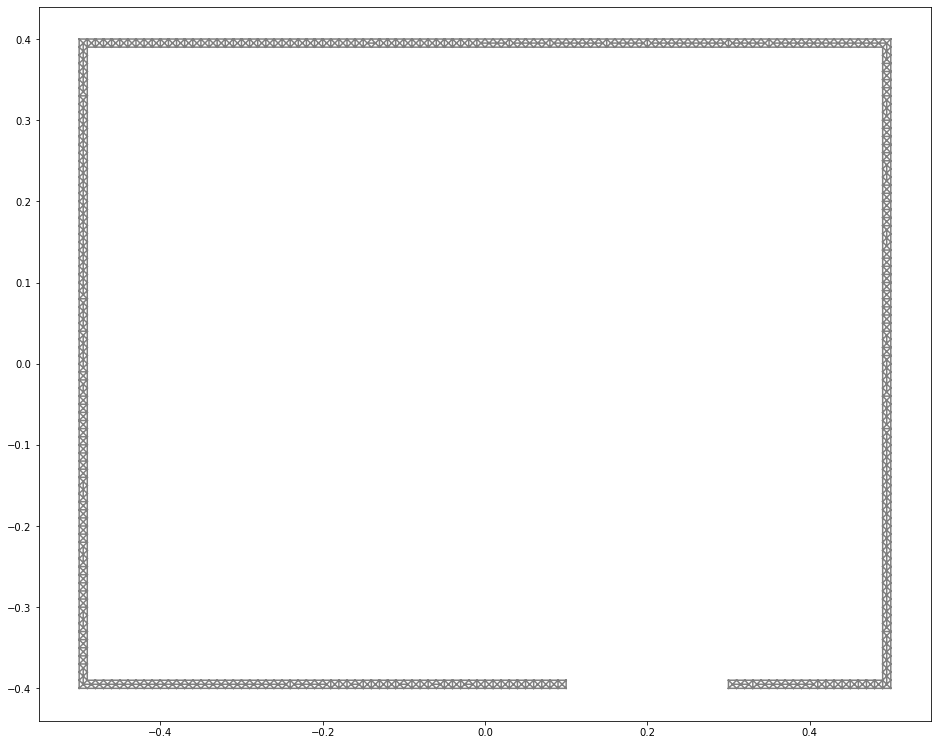

In [52]:
# horizon and mesh size
h = 0.01

# Domain
L = 1
W = 0.8

# Parameters for hole

# square hole center
xc1 = 0
xc2 = 0
z = 0
Lin = L - 2*h
Win = W - 2*h

# hole in bottom edge
bottom_edge_hole_x_left = 0.1*L
bottom_edge_hole_x_right = 0.3*L

# create mesh dir and filename
mesh_dir = './rectangle_with_rectangle_hole_with_opening/'
os.makedirs(mesh_dir, exist_ok = True)

mesh_tag = 'mesh' + '_h_{:4.6e}'.format(h) 
mesh_fname = mesh_dir + mesh_tag

# create gmsh input file
geof = open(mesh_fname + '.geo','w')
geof.write("cl__1 = 1;\n")
geof.write("Mesh.MshFileVersion = 2.2;\n")

# four corners of domain and two points on bottom edge where opening will be created
p_id = 1
p_id = write_point_geo(geof, p_id, [-0.5*L, -0.5*W, z], h) # point 1
p_id = write_point_geo(geof, p_id, [0.5*L, -0.5*W, z], h)
p_id = write_point_geo(geof, p_id, [0.5*L, 0.5*W, z], h)
p_id = write_point_geo(geof, p_id, [-0.5*L, 0.5*W, z], h)

p_id = write_point_geo(geof, p_id, [bottom_edge_hole_x_left, -0.5*W, z], h)
p_id = write_point_geo(geof, p_id, [bottom_edge_hole_x_right, -0.5*W, z], h) # point 6

# four points on rectangle hole and two points on bottom edge where opening will be created
p_id = write_point_geo(geof, p_id, [-0.5*Lin, -0.5*Win, z], h) # point 7
p_id = write_point_geo(geof, p_id, [0.5*Lin, -0.5*Win, z], h)
p_id = write_point_geo(geof, p_id, [0.5*Lin, 0.5*Win, z], h)
p_id = write_point_geo(geof, p_id, [-0.5*Lin, 0.5*Win, z], h)

p_id = write_point_geo(geof, p_id, [bottom_edge_hole_x_left, -0.5*Win, z], h)
p_id = write_point_geo(geof, p_id, [bottom_edge_hole_x_right, -0.5*Win, z], h) # point 12


# lines to form outer boundary (careful with the bottom edge as this will be divided into two lines)
l_id = 1
l_id = write_line_geo(geof, l_id, 1, 5) # line 1
l_id = write_line_geo(geof, l_id, 6, 2)
l_id = write_line_geo(geof, l_id, 2, 3)
l_id = write_line_geo(geof, l_id, 3, 4)
l_id = write_line_geo(geof, l_id, 4, 1) # line 5

# lines to form inner boundary
l_id = write_line_geo(geof, l_id, 7, 11) # line 6
l_id = write_line_geo(geof, l_id, 12, 8)
l_id = write_line_geo(geof, l_id, 8, 9)
l_id = write_line_geo(geof, l_id, 9, 10)
l_id = write_line_geo(geof, l_id, 10, 7) # line 10

# line connecting bottom edge hole
l_id = write_line_geo(geof, l_id, 5, 11) # line 11
l_id = write_line_geo(geof, l_id, 12, 6) # line 12

# line loop to define surface
# this works too ---> geof.write("Curve Loop(13) = {10, 6, -11, -1, -5, -4, -3, -2, -12, 7, 8, 9};\n")
geof.write("Curve Loop(13) = {7, 8, 9, 10, 6, -11, -1, -5, -4, -3, -2, -12};\n")

# define surface
geof.write("Plane Surface(14) = {13};\n")

# define physical groups
geof.write("Physical Point(15) = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12};\n")

geof.write("Physical Line(16) = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12};\n")

geof.write("Physical Surface(17) = {14};\n")

# close file
geof.close()


## meshing
os.system('gmsh ' + mesh_fname + '.geo -2')
os.system('gmsh ' + mesh_fname + '.geo -2 -o ' + mesh_fname + '.vtk')

## convert mesh
mesh_from_file = meshio.read(mesh_fname + ".msh")

triangle_mesh = create_mesh(mesh_from_file, "triangle", prune_z=True)
meshio.write(mesh_fname + ".xdmf", triangle_mesh)

line_mesh = create_mesh(mesh_from_file, "line", prune_z=True)
meshio.write(mesh_fname + "_facet.xdmf", line_mesh)

## plot
mesh = dl.Mesh()
# read xdmf file in fenics
with dl.XDMFFile(mesh_fname + '.xdmf') as infile:
    infile.read(mesh)

mvc = dl.MeshValueCollection("size_t", mesh, 2)
with dl.XDMFFile(mesh_fname + '_facet.xdmf') as infile:
    infile.read(mvc, "name_to_read")
    
sub = dl.cpp.mesh.MeshFunctionSizet(mesh, mvc)

# plot
plt.figure(figsize=(16,16))
dl.plot(mesh)

# save figures
plt.savefig(mesh_fname + '.pdf')
plt.savefig(mesh_fname + '.png')

plt.show()

## Rectangle (square) with rectangle (square) void and rectangle opening and protrusion


<img src="./rectangle_with_rectangle_hole_with_opening_and_protrusion/drawing.jpg" style="width:400px;">



Note we need following ordering to define curve loop in `.geo` file:
- `curve_loop = {13, 14, 15, 16, 17, 18, 6, 7, 8, 9, 10, -11, -1, -5, -4, -3, -2, -12}` 
- where `line 11 = {5, 12}` and `line 12 = {13, 6}`

Info    : Running '/Users/prashant/opt/anaconda3/envs/confen/bin/gmsh ./rectangle_with_rectangle_hole_with_opening_and_protrusion/mesh_h_2.000000e-04.geo -2' [Gmsh 4.12.2, 1 node, max. 1 thread]
Info    : Started on Fri Jun 14 00:38:57 2024
Info    : Reading './rectangle_with_rectangle_hole_with_opening_and_protrusion/mesh_h_2.000000e-04.geo'...
Info    : Done reading './rectangle_with_rectangle_hole_with_opening_and_protrusion/mesh_h_2.000000e-04.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 40%] Meshing curve 7 (Line)
Info    : [ 40%] Meshing curve 8 (Line)
Info    : [ 50%] Meshing curve 9 (Line)
Info    : [ 50%] Meshing curve 10 (Line)
Info    : [ 60%] Meshing curve 11 (Line)
Info    : [ 70%] Meshing curve 12 (Line)
Info    : [ 70%] Meshing curve 13 (L

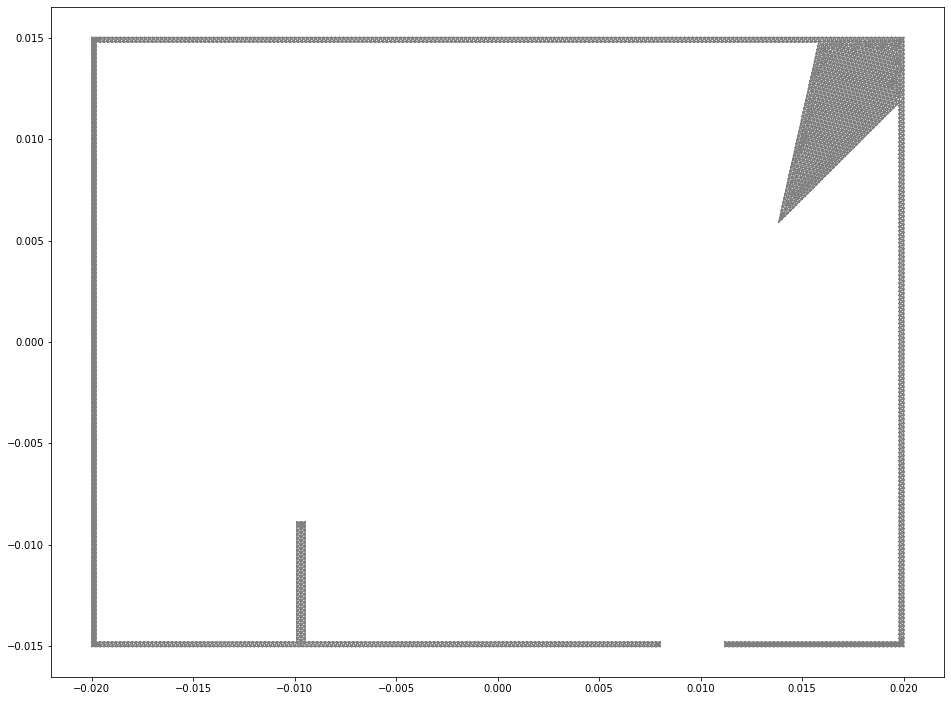

In [53]:
# Domain
L = 0.04
W = 0.03
h = 0.0002

# Parameters for hole

# square hole center
xc1 = 0
xc2 = 0
z = 0
Lin = L - 2*h
Win = W - 2*h

# hole in bottom edge
out_bottom_edge_hole_x_left = [0.2*L, -0.5*W, z]
out_bottom_edge_hole_x_right = [0.28*L, -0.5*W, z]
in_bottom_edge_hole_x_left = [0.2*L, -0.5*Win, z]
in_bottom_edge_hole_x_right = [0.28*L, -0.5*Win, z]

# triangle protrusion on upper-right corner
tri_protrsn_coord_inside = [0.5*Lin - 0.15*Lin, 0.5*Win - 0.3*Win, z]
tri_protrusn_coord_right_edge = [0.5*Lin, 0.5*Win - 0.1*Win, z]
tri_protrusn_coord_top_edge = [0.5*Lin - 0.1*Lin, 0.5*Win, z]

# rectangular protrusion at bottom
rect_protrsn_1_coord_inside = [-0.5*Lin + 0.25*Lin, -0.5*Win + 0.2*Win, z]
rect_protrsn_2_coord_inside = [-0.5*Lin + 0.25*Lin + 2*h, -0.5*Win + 0.2*Win, z]
rect_protrsn_1_coord_bottom_edge = [-0.5*Lin + 0.25*Lin, -0.5*Win, z]
rect_protrsn_2_coord_bottom_edge = [-0.5*Lin + 0.25*Lin + 2*h, -0.5*Win, z]


# create mesh dir and filename
mesh_dir = './rectangle_with_rectangle_hole_with_opening_and_protrusion/'
os.makedirs(mesh_dir, exist_ok = True)

mesh_tag = 'mesh' + '_h_{:4.6e}'.format(h) 
mesh_fname = mesh_dir + mesh_tag

# create gmsh input file
geof = open(mesh_fname + '.geo','w')
geof.write("cl__1 = 1;\n")
geof.write("Mesh.MshFileVersion = 2.2;\n")

# four corners of domain and two points on bottom edge where opening will be created
p_id = 1
p_id = write_point_geo(geof, p_id, [-0.5*L, -0.5*W, z], h) 
p_id = write_point_geo(geof, p_id, [0.5*L, -0.5*W, z], h)
p_id = write_point_geo(geof, p_id, [0.5*L, 0.5*W, z], h)
p_id = write_point_geo(geof, p_id, [-0.5*L, 0.5*W, z], h)

p_id = write_point_geo(geof, p_id, out_bottom_edge_hole_x_left, h)
p_id = write_point_geo(geof, p_id, out_bottom_edge_hole_x_right, h) 

# four points on rectangle hole and two points on bottom edge where opening will be created
p_id = write_point_geo(geof, p_id, [-0.5*Lin, -0.5*Win, z], h)

p_id = write_point_geo(geof, p_id, rect_protrsn_1_coord_bottom_edge, h)
p_id = write_point_geo(geof, p_id, rect_protrsn_1_coord_inside, h)
p_id = write_point_geo(geof, p_id, rect_protrsn_2_coord_inside, h)
p_id = write_point_geo(geof, p_id, rect_protrsn_2_coord_bottom_edge, h)

p_id = write_point_geo(geof, p_id, in_bottom_edge_hole_x_left, h) 
p_id = write_point_geo(geof, p_id, in_bottom_edge_hole_x_right, h) 

p_id = write_point_geo(geof, p_id, [0.5*Lin, -0.5*Win, z], h)

p_id = write_point_geo(geof, p_id, tri_protrusn_coord_right_edge, h)
p_id = write_point_geo(geof, p_id, tri_protrsn_coord_inside, h)
p_id = write_point_geo(geof, p_id, tri_protrusn_coord_top_edge, h) 

p_id = write_point_geo(geof, p_id, [-0.5*Lin, 0.5*Win, z], h)

# lines to form outer boundary (careful with the bottom edge as this will be divided into two lines)
l_id = 1
l_id = write_line_geo(geof, l_id, 1, 5) 
l_id = write_line_geo(geof, l_id, 6, 2)
l_id = write_line_geo(geof, l_id, 2, 3)
l_id = write_line_geo(geof, l_id, 3, 4)
l_id = write_line_geo(geof, l_id, 4, 1)

l_id = write_line_geo(geof, l_id, 7, 8)
l_id = write_line_geo(geof, l_id, 8, 9)
l_id = write_line_geo(geof, l_id, 9, 10)
l_id = write_line_geo(geof, l_id, 10, 11)
l_id = write_line_geo(geof, l_id, 11, 12)

l_id = write_line_geo(geof, l_id, 5, 12)
l_id = write_line_geo(geof, l_id, 13, 6)

l_id = write_line_geo(geof, l_id, 13, 14)
l_id = write_line_geo(geof, l_id, 14, 15)
l_id = write_line_geo(geof, l_id, 15, 16)
l_id = write_line_geo(geof, l_id, 16, 17)
l_id = write_line_geo(geof, l_id, 17, 18)
l_id = write_line_geo(geof, l_id, 18, 7)

# line loop to define surface
# this works too ---> geof.write("Curve Loop(13) = {10, 6, -11, -1, -5, -4, -3, -2, -12, 7, 8, 9};\n")
geof.write("Curve Loop(19) = {13, 14, 15, 16, 17, 18, 6, 7, 8, 9, 10, -11, -1, -5, -4, -3, -2, -12};\n")

# define surface
geof.write("Plane Surface(20) = {19};\n")

# define physical groups
geof.write("Physical Point(21) = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18};\n")

geof.write("Physical Line(22) = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18};\n")

geof.write("Physical Surface(23) = {20};\n")

# close file
geof.close()


## meshing
os.system('gmsh ' + mesh_fname + '.geo -2')
os.system('gmsh ' + mesh_fname + '.geo -2 -o ' + mesh_fname + '.vtk')

## convert mesh
mesh_from_file = meshio.read(mesh_fname + ".msh")

triangle_mesh = create_mesh(mesh_from_file, "triangle", prune_z=True)
meshio.write(mesh_fname + ".xdmf", triangle_mesh)

line_mesh = create_mesh(mesh_from_file, "line", prune_z=True)
meshio.write(mesh_fname + "_facet.xdmf", line_mesh)

## plot
mesh = dl.Mesh()
# read xdmf file in fenics
with dl.XDMFFile(mesh_fname + '.xdmf') as infile:
    infile.read(mesh)

mvc = dl.MeshValueCollection("size_t", mesh, 2)
with dl.XDMFFile(mesh_fname + '_facet.xdmf') as infile:
    infile.read(mvc, "name_to_read")
    
sub = dl.cpp.mesh.MeshFunctionSizet(mesh, mvc)

# plot
plt.figure(figsize=(16,16))
dl.plot(mesh)

# save figures
plt.savefig(mesh_fname + '.pdf')
plt.savefig(mesh_fname + '.png')

plt.show()

## Rectangle (square) with rectangle (square) void and rectangle opening and protrusion - type 2


<img src="./rectangle_with_rectangle_hole_with_opening_and_protrusion_type2/drawing.jpg" style="width:400px;">

Note we need following ordering to define curve loop in `.geo` file:
- `curve_loop = {12, 13, 14, 15, 16, 17, 6, 7, 8, 9, -10, -1, -5, -4, -3, -2, -11}` 
- where `line 10 = {5, 12}` and `line 11 = {13, 6}`.

Info    : Running '/Users/prashant/opt/anaconda3/envs/confen/bin/gmsh ./rectangle_with_rectangle_hole_with_opening_and_protrusion_type2/mesh_h_2.000000e-04.geo -2' [Gmsh 4.12.2, 1 node, max. 1 thread]
Info    : Started on Fri Jun 14 03:40:28 2024
Info    : Reading './rectangle_with_rectangle_hole_with_opening_and_protrusion_type2/mesh_h_2.000000e-04.geo'...
Info    : Done reading './rectangle_with_rectangle_hole_with_opening_and_protrusion_type2/mesh_h_2.000000e-04.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 40%] Meshing curve 7 (Circle)
Info    : [ 40%] Meshing curve 8 (Circle)
Info    : [ 50%] Meshing curve 9 (Line)
Info    : [ 50%] Meshing curve 10 (Circle)
Info    : [ 60%] Meshing curve 11 (Circle)
Info    : [ 60%] Meshing curve 12 (Circle)
Info    

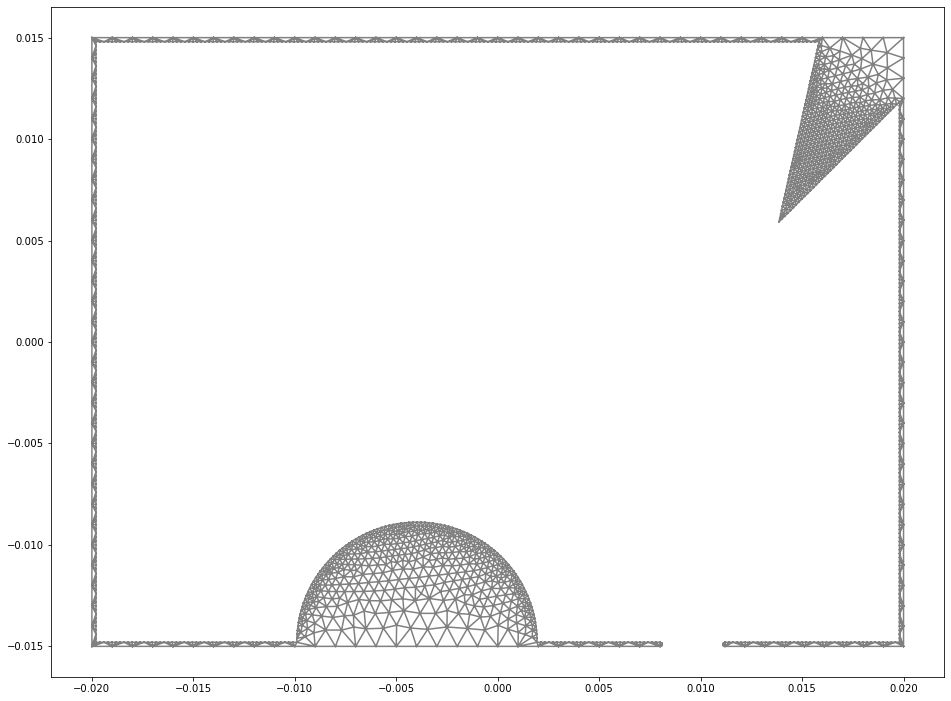

In [73]:
# Domain
L = 0.04
W = 0.03
h = 0.0002
hin = h
hout = 5*h

# Parameters for hole

# square hole center
xc1 = 0
xc2 = 0
z = 0
Lin = L - 2*h
Win = W - 2*h

# hole in bottom edge
hole_radius = 0.5 * (0.5*(W - Win))# half of thickness in vertical direction
# left side points
p5 = [0.2*L, -0.5*W, z]
p12 = [0.2*L, -0.5*Win, z]
p13 = [0.2*L, -0.5*W + hole_radius, z]
p14 = [0.2*L + hole_radius, -0.5*W + hole_radius, z]

p6 = [0.28*L, -0.5*W, z]
p16 = [0.28*L, -0.5*Win, z]
p17 = [0.28*L, -0.5*W + hole_radius, z]
p15 = [0.28*L - hole_radius, -0.5*W + hole_radius, z]

# triangle protrusion on upper-right corner
p20 = [0.5*Lin - 0.15*Lin, 0.5*Win - 0.3*Win, z]
p19 = [0.5*Lin, 0.5*Win - 0.1*Win, z]
p21 = [0.5*Lin - 0.1*Lin, 0.5*Win, z]

# circular protrusion at bottom
circ_protrsn_r = 0.2*Win
p8 = [-0.5*Lin + 0.25*Lin, -0.5*Win, z]
p11 = [-0.5*Lin + 0.25*Lin + 2*circ_protrsn_r, -0.5*Win, z]
p9 = [-0.5*Lin + 0.25*Lin + circ_protrsn_r, -0.5*Win, z]
p10 = [-0.5*Lin + 0.25*Lin + circ_protrsn_r, -0.5*Win + circ_protrsn_r, z]


# create mesh dir and filename
mesh_dir = './rectangle_with_rectangle_hole_with_opening_and_protrusion_type2/'
os.makedirs(mesh_dir, exist_ok = True)

mesh_tag = 'mesh' + '_h_{:4.6e}'.format(h) 
mesh_fname = mesh_dir + mesh_tag

# create gmsh input file
geof = open(mesh_fname + '.geo','w')
geof.write("cl__1 = 1;\n")
geof.write("Mesh.MshFileVersion = 2.2;\n")

# ---------------------- #
# points                 #
# ---------------------- #
# points (as shown in drawing above)
p_id = 1
# points on outer side
p_id = write_point_geo(geof, p_id, [-0.5*L, -0.5*W, z], hout) 
p_id = write_point_geo(geof, p_id, [0.5*L, -0.5*W, z], hout)
p_id = write_point_geo(geof, p_id, [0.5*L, 0.5*W, z], hout)
p_id = write_point_geo(geof, p_id, [-0.5*L, 0.5*W, z], hout)

p_id = write_point_geo(geof, p_id, p5, hout)
p_id = write_point_geo(geof, p_id, p6, hout) 

# points on inner side
p_id = write_point_geo(geof, p_id, [-0.5*Lin, -0.5*Win, z], h)

## circular protrusion points
p_id = write_point_geo(geof, p_id, p8, h)
p_id = write_point_geo(geof, p_id, p9, hout) # treat this internal point as control for coarse mesh
p_id = write_point_geo(geof, p_id, p10, h)
p_id = write_point_geo(geof, p_id, p11, h)

# circular opening points
p_id = write_point_geo(geof, p_id, p12, h)
p_id = write_point_geo(geof, p_id, p13, hout)
p_id = write_point_geo(geof, p_id, p14, h)

p_id = write_point_geo(geof, p_id, p15, h)
p_id = write_point_geo(geof, p_id, p16, h)
p_id = write_point_geo(geof, p_id, p17, hout)

p_id = write_point_geo(geof, p_id, [0.5*Lin, -0.5*Win, z], h)

# triangular protrusion
p_id = write_point_geo(geof, p_id, p19, h)
p_id = write_point_geo(geof, p_id, p20, h)
p_id = write_point_geo(geof, p_id, p21, h) 

p_id = write_point_geo(geof, p_id, [-0.5*Lin, 0.5*Win, z], h)

# ---------------------- #
# lines                  #
# ---------------------- #
# lines to form outer boundary (careful with the bottom edge as this will be divided into two lines)
l_id = 1
l_id = write_line_geo(geof, l_id, 1, 5) 
l_id = write_line_geo(geof, l_id, 6, 2)
l_id = write_line_geo(geof, l_id, 2, 3)
l_id = write_line_geo(geof, l_id, 3, 4)
l_id = write_line_geo(geof, l_id, 4, 1)

l_id = write_line_geo(geof, l_id, 7, 8)

# circular arc for protrusion
l_id = write_cir_line_geo(geof, l_id, 8, 9, 10)
l_id = write_cir_line_geo(geof, l_id, 10, 9, 11)

l_id = write_line_geo(geof, l_id, 11, 12)

# circular arc for opening
l_id = write_cir_line_geo(geof, l_id, 12, 13, 14)
l_id = write_cir_line_geo(geof, l_id, 14, 13, 5)

l_id = write_cir_line_geo(geof, l_id, 16, 17, 15)
l_id = write_cir_line_geo(geof, l_id, 15, 17, 6)

l_id = write_line_geo(geof, l_id, 16, 18)
l_id = write_line_geo(geof, l_id, 18, 19)
l_id = write_line_geo(geof, l_id, 19, 20)
l_id = write_line_geo(geof, l_id, 20, 21)
l_id = write_line_geo(geof, l_id, 21, 22)
l_id = write_line_geo(geof, l_id, 22, 7)

# ---------------------- #
# line loops, ...        #
# ---------------------- #
# line loop to define surface
# this works too ---> geof.write("Curve Loop(13) = {10, 6, -11, -1, -5, -4, -3, -2, -12, 7, 8, 9};\n")
geof.write("Curve Loop(20) = {14, 15, 16, 17, 18, 19, 6, 7, 8, 9, 10, 11, -1, -5, -4, -3, -2, -12, -13};\n")

# define surface
geof.write("Plane Surface(21) = {20};\n")

# define physical groups
geof.write("Physical Point(22) = {1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 16, 17, 18, 19, 20, 21, 22};\n")

geof.write("Physical Line(23) = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19};\n")

geof.write("Physical Surface(24) = {21};\n")

# close file
geof.close()


## meshing
os.system('gmsh ' + mesh_fname + '.geo -2')
os.system('gmsh ' + mesh_fname + '.geo -2 -o ' + mesh_fname + '.vtk')

## convert mesh
mesh_from_file = meshio.read(mesh_fname + ".msh")

triangle_mesh = create_mesh(mesh_from_file, "triangle", prune_z=True)
meshio.write(mesh_fname + ".xdmf", triangle_mesh)

line_mesh = create_mesh(mesh_from_file, "line", prune_z=True)
meshio.write(mesh_fname + "_facet.xdmf", line_mesh)

## plot
mesh = dl.Mesh()
# read xdmf file in fenics
with dl.XDMFFile(mesh_fname + '.xdmf') as infile:
    infile.read(mesh)

mvc = dl.MeshValueCollection("size_t", mesh, 2)
with dl.XDMFFile(mesh_fname + '_facet.xdmf') as infile:
    infile.read(mvc, "name_to_read")
    
sub = dl.cpp.mesh.MeshFunctionSizet(mesh, mvc)

# plot
plt.figure(figsize=(16,16))
dl.plot(mesh)

# save figures
plt.savefig(mesh_fname + '.pdf')
plt.savefig(mesh_fname + '.png')

plt.show()

## Rectangle (square) with rectangle (square) void and rectangle opening and protrusion - type 3


<img src="./rectangle_with_rectangle_hole_with_opening_and_protrusion_type3/drawing.jpg" style="width:400px;">

Note we need following ordering to define curve loop in `.geo` file:
- `curve_loop = {13, 14, 15, 16, 17, 18, 6, 7, 8, 9, 10, -11, -1, -5, -4, -3, -2, -12}` 
- where `line 11 = {5, 12}` and `line 12 = {13, 6}`

Info    : Running '/Users/prashant/opt/anaconda3/envs/confen/bin/gmsh ./rectangle_with_rectangle_hole_with_opening_and_protrusion_type3/mesh_h_2.000000e-04.geo -2' [Gmsh 4.12.2, 1 node, max. 1 thread]
Info    : Started on Fri Jun 14 03:40:30 2024
Info    : Reading './rectangle_with_rectangle_hole_with_opening_and_protrusion_type3/mesh_h_2.000000e-04.geo'...
Info    : Done reading './rectangle_with_rectangle_hole_with_opening_and_protrusion_type3/mesh_h_2.000000e-04.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 40%] Meshing curve 7 (Circle)
Info    : [ 50%] Meshing curve 8 (Circle)
Info    : [ 50%] Meshing curve 9 (Line)
Info    : [ 60%] Meshing curve 10 (Line)
Info    : [ 60%] Meshing curve 11 (Line)
Info    : [ 70%] Meshing curve 12 (Line)
Info    : [ 80

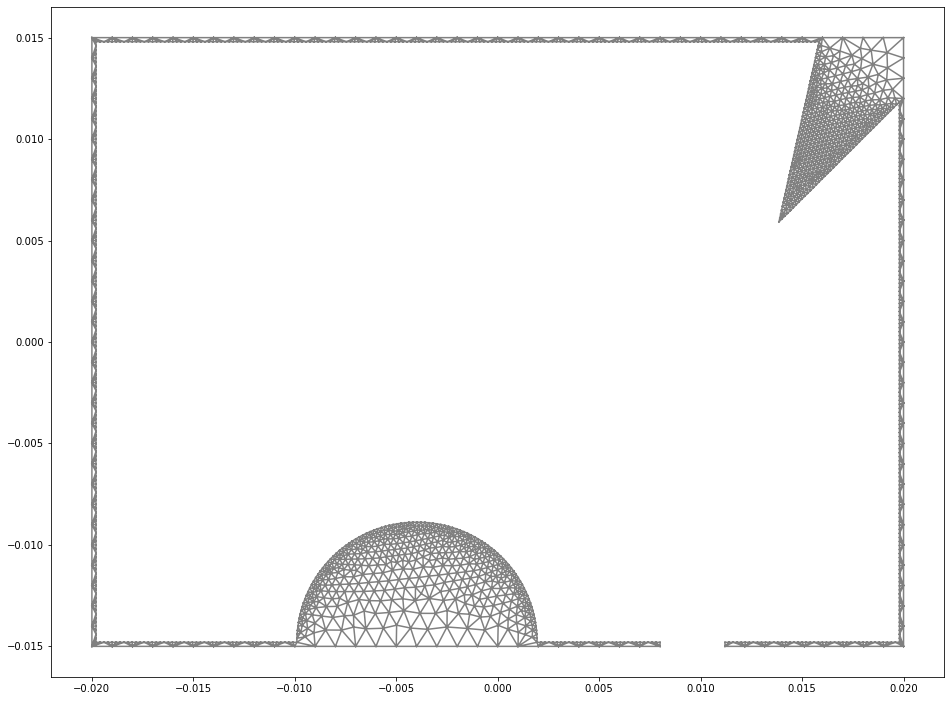

In [74]:
# Domain
L = 0.04
W = 0.03
h = 0.0002
hin = h
hout = 5*h

# Parameters for hole

# square hole center
xc1 = 0
xc2 = 0
z = 0
Lin = L - 2*h
Win = W - 2*h

# hole in bottom edge
hole_radius = 0.5 * (0.5*(W - Win))# half of thickness in vertical direction
# left side points
p5 = [0.2*L, -0.5*W, z]
p12 = [0.2*L, -0.5*Win, z]

p6 = [0.28*L, -0.5*W, z]
p13 = [0.28*L, -0.5*Win, z]

# triangle protrusion on upper-right corner
p16 = [0.5*Lin - 0.15*Lin, 0.5*Win - 0.3*Win, z]
p15 = [0.5*Lin, 0.5*Win - 0.1*Win, z]
p17 = [0.5*Lin - 0.1*Lin, 0.5*Win, z]

# circular protrusion at bottom
circ_protrsn_r = 0.2*Win
p8 = [-0.5*Lin + 0.25*Lin, -0.5*Win, z]
p11 = [-0.5*Lin + 0.25*Lin + 2*circ_protrsn_r, -0.5*Win, z]
p9 = [-0.5*Lin + 0.25*Lin + circ_protrsn_r, -0.5*Win, z]
p10 = [-0.5*Lin + 0.25*Lin + circ_protrsn_r, -0.5*Win + circ_protrsn_r, z]


# create mesh dir and filename
mesh_dir = './rectangle_with_rectangle_hole_with_opening_and_protrusion_type3/'
os.makedirs(mesh_dir, exist_ok = True)

mesh_tag = 'mesh' + '_h_{:4.6e}'.format(h) 
mesh_fname = mesh_dir + mesh_tag

# create gmsh input file
geof = open(mesh_fname + '.geo','w')
geof.write("cl__1 = 1;\n")
geof.write("Mesh.MshFileVersion = 2.2;\n")

# ---------------------- #
# points                 #
# ---------------------- #
# points (as shown in drawing above)
p_id = 1
# points on outer side
p_id = write_point_geo(geof, p_id, [-0.5*L, -0.5*W, z], hout) 
p_id = write_point_geo(geof, p_id, [0.5*L, -0.5*W, z], hout)
p_id = write_point_geo(geof, p_id, [0.5*L, 0.5*W, z], hout)
p_id = write_point_geo(geof, p_id, [-0.5*L, 0.5*W, z], hout)

p_id = write_point_geo(geof, p_id, p5, hout)
p_id = write_point_geo(geof, p_id, p6, hout) 

# points on inner side
p_id = write_point_geo(geof, p_id, [-0.5*Lin, -0.5*Win, z], h)

## circular protrusion points
p_id = write_point_geo(geof, p_id, p8, h)
p_id = write_point_geo(geof, p_id, p9, hout) # treat this internal point as control for coarse mesh
p_id = write_point_geo(geof, p_id, p10, h)
p_id = write_point_geo(geof, p_id, p11, h)

# opening points
p_id = write_point_geo(geof, p_id, p12, h)
p_id = write_point_geo(geof, p_id, p13, h)

p_id = write_point_geo(geof, p_id, [0.5*Lin, -0.5*Win, z], h)

# triangular protrusion
p_id = write_point_geo(geof, p_id, p15, h)
p_id = write_point_geo(geof, p_id, p16, h)
p_id = write_point_geo(geof, p_id, p17, h) 

p_id = write_point_geo(geof, p_id, [-0.5*Lin, 0.5*Win, z], h)

# ---------------------- #
# lines                  #
# ---------------------- #
# lines to form outer boundary (careful with the bottom edge as this will be divided into two lines)
l_id = 1
l_id = write_line_geo(geof, l_id, 1, 5) 
l_id = write_line_geo(geof, l_id, 6, 2)
l_id = write_line_geo(geof, l_id, 2, 3)
l_id = write_line_geo(geof, l_id, 3, 4)
l_id = write_line_geo(geof, l_id, 4, 1)

l_id = write_line_geo(geof, l_id, 7, 8)

# circular arc for protrusion
l_id = write_cir_line_geo(geof, l_id, 8, 9, 10)
l_id = write_cir_line_geo(geof, l_id, 10, 9, 11)

l_id = write_line_geo(geof, l_id, 11, 12)

# opening
l_id = write_line_geo(geof, l_id, 5, 12)
l_id = write_line_geo(geof, l_id, 13, 6)

l_id = write_line_geo(geof, l_id, 13, 14)
l_id = write_line_geo(geof, l_id, 14, 15)
l_id = write_line_geo(geof, l_id, 15, 16)
l_id = write_line_geo(geof, l_id, 16, 17)
l_id = write_line_geo(geof, l_id, 17, 18)
l_id = write_line_geo(geof, l_id, 18, 7)

# ---------------------- #
# line loops, ...        #
# ---------------------- #
# line loop to define surface
geof.write("Curve Loop(20) = {12, 13, 14, 15, 16, 17, 6, 7, 8, 9, -10, -1, -5, -4, -3, -2, -11};\n")

# define surface
geof.write("Plane Surface(21) = {20};\n")

# define physical groups
geof.write("Physical Point(22) = {1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 16, 17, 18};\n")

geof.write("Physical Line(23) = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17};\n")

geof.write("Physical Surface(24) = {21};\n")

# close file
geof.close()


## meshing
os.system('gmsh ' + mesh_fname + '.geo -2')
os.system('gmsh ' + mesh_fname + '.geo -2 -o ' + mesh_fname + '.vtk')

## convert mesh
mesh_from_file = meshio.read(mesh_fname + ".msh")

triangle_mesh = create_mesh(mesh_from_file, "triangle", prune_z=True)
meshio.write(mesh_fname + ".xdmf", triangle_mesh)

line_mesh = create_mesh(mesh_from_file, "line", prune_z=True)
meshio.write(mesh_fname + "_facet.xdmf", line_mesh)

## plot
mesh = dl.Mesh()
# read xdmf file in fenics
with dl.XDMFFile(mesh_fname + '.xdmf') as infile:
    infile.read(mesh)

mvc = dl.MeshValueCollection("size_t", mesh, 2)
with dl.XDMFFile(mesh_fname + '_facet.xdmf') as infile:
    infile.read(mvc, "name_to_read")
    
sub = dl.cpp.mesh.MeshFunctionSizet(mesh, mvc)

# plot
plt.figure(figsize=(16,16))
dl.plot(mesh)

# save figures
plt.savefig(mesh_fname + '.pdf')
plt.savefig(mesh_fname + '.png')

plt.show()